Load Data and Plot Uncorrected Imaging Volume

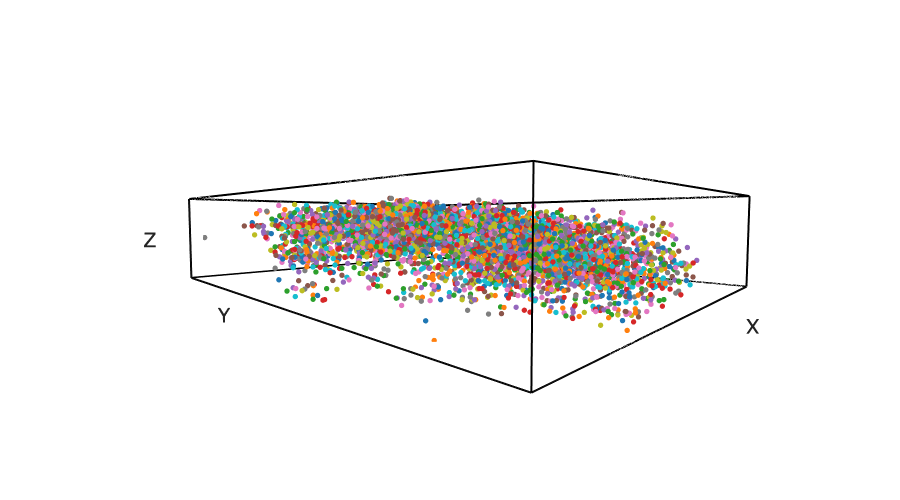

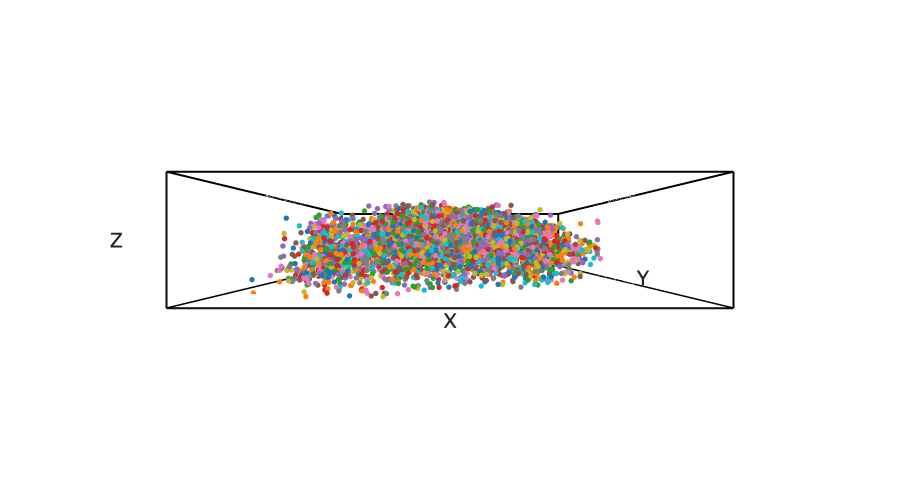

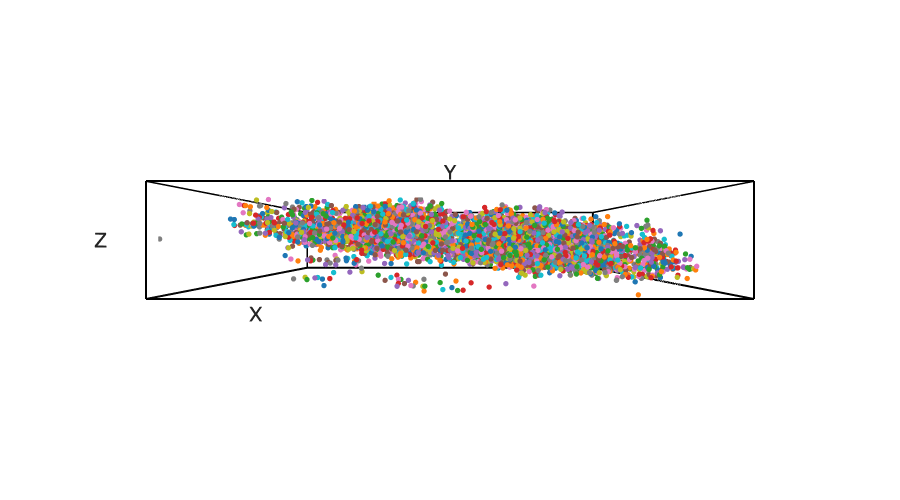

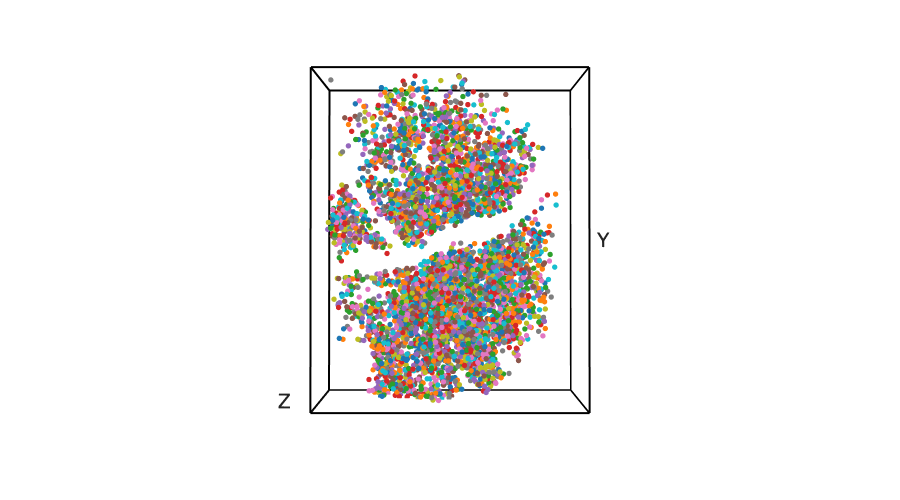

In [2]:
import glob
import numpy as np
from skimage.measure import label, regionprops
import plotly.express as px
import plotly.io as pio
import pandas as pd

file_path = "/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/rAAV/"
exp_names = [
    "retr02",
#     "retr00",
#     "retr04",
#     "retr07",
#     "retr08",
#     "retr09",
#     "retr10"
            ]

for exp in exp_names:
    curr_path = file_path + exp + "/"
    file_name = glob.glob(curr_path + "*.npy")
    in_data = np.load(file_name[0], allow_pickle=True)
    data = in_data.item()
    # There must be a better way
    def draw_bbox(xlims, ylims, zlims):
        X = []
        Y = []
        Z = []
        for x in xlims:
            for y in ylims:
                for z in zlims:
                    X.append(x)
                    Y.append(y)
                    Z.append(z)
        for x in xlims:
            for z in zlims:
                for y in ylims:
                    X.append(x)
                    Y.append(y)
                    Z.append(z)
        for z in zlims:
            for y in ylims:
                for x in xlims:
                    X.append(x)
                    Y.append(y)
                    Z.append(z)
        return X, Y, Z

    masks = data["masks"]
    regions = regionprops(masks)

    X, Y, Z = draw_bbox([795,0], [0,899], [0,masks.shape[0]-1])
    df = pd.DataFrame(dict(
        X=X, 
        Y=Y, 
        Z=Z,
        line_group=np.repeat(range(int(len(X)/2)), 2)
                     ))
    fig = px.line_3d(df, x='X', y='Y', z='Z', line_group='line_group', template="simple_white")
    fig.update_traces(line_color="black", line_width=4)
    for region in regions:
        z, y, x = region.centroid
        fig.add_scatter3d(x=[x], y=[y], z=[z])
    camera = dict(eye=dict(x=12, y=12, z=0.85))
    fig.update_layout(
        scene = dict(
            xaxis = dict(ticks="", range=[795, 0], showgrid=False, showticklabels=False, title_font_size=20),
            yaxis = dict(ticks="", range=[0, 899], showgrid=False, showticklabels=False, title_font_size=20),
            zaxis = dict(ticks="", range=[0, masks.shape[0]-1], showgrid=False, showticklabels=False, title_font_size=20),
            aspectmode="manual",
            aspectratio=dict(x=13.7, y=17, z=(masks.shape[0]*5)/100),),
        width=900,
        showlegend=False,
        scene_camera=camera
                    )
    fig.update_traces(marker=dict(size=3,
                                  opacity=1))
    fig.show("png")
    pio.write_image(fig, curr_path + "XYZ_view.png", scale=3)

    fig.update_layout(scene_camera=dict(eye=dict(x=0, y=19, z=0)))
    fig.show("png")
    pio.write_image(fig, curr_path + "XZ_view.png", scale=3)

    fig.update_layout(scene_camera=dict(eye=dict(x=19, y=0, z=0)))
    fig.show("png")
    pio.write_image(fig, curr_path + "YZ_view.png", scale=3)

    fig.update_layout(scene_camera=dict(eye=dict(x=0, y=0.1, z=23)))
    fig.show("png")
    pio.write_image(fig, curr_path + "XY_view.png", scale=3)

Estimate Base and Direction of Stack Slope

In [4]:
import sys
from PyQt5 import QtCore, QtGui, QtWidgets
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg, NavigationToolbar2QT as NavigationToolbar
from matplotlib.figure import Figure
from matplotlib.backend_bases import MouseButton
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
from tifffile import imread
from math import radians, cos, sqrt
import numpy as np

stack_path = "/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/rAAV/retr02/"
stack_name = "retr02_002_001_stackred.tif"
stack = imread(stack_path + stack_name)


class MplCanvas(FigureCanvasQTAgg):
    """"""
    def __init__(self, parent=None, width=3, height=3.5, dpi=200):
        """"""
        fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = fig.add_subplot(111)
        super(MplCanvas, self).__init__(fig)


class MainWindow(QtWidgets.QMainWindow):
    """"""
    def __init__(self, *args, **kwargs):
        """"""
        super(MainWindow, self).__init__(*args, **kwargs)
        sc = MplCanvas(self, width=3, height=3.5, dpi=200)
        # Draw static reference frame
        sc.axes.imshow(stack[0], cmap='gray')
        sc.axes.axis("off")
        # Plot vector base position and direction
        self.arrow_coords = [0, 0, 300, 300]
        self.arrow = sc.axes.arrow(*self.arrow_coords, head_width=10, color="r")

        # Create toolbar
        toolbar = NavigationToolbar(sc, self)
        # Create, configure, and connect to slider for z-stack depth
        self.slider_z = QtWidgets.QSlider(QtCore.Qt.Vertical)
        self.slider_z.setMinimum(0)
        self.slider_z.setMaximum(stack.shape[0]-1)
        self.slider_z.setTickInterval(1)
        self.slider_z.valueChanged.connect(lambda state, ax = sc: self.zsliderValueChange(state, ax))
        self.slider_z.setValue(stack.shape[0]-1)
        # Create, configure, and connect to slider for x-axis position of vector
        self.slider_x = QtWidgets.QSlider(QtCore.Qt.Horizontal)
        self.slider_x.setMinimum(0)
        self.slider_x.setMaximum(stack.shape[2]-1)
        self.slider_x.setTickInterval(1)
        self.slider_x.valueChanged.connect(lambda state, ax = sc: self.xsliderValueChange(state, ax))
        self.slider_x.setValue(0)
        # Create, configure, and connect to slider for y-axis position of vector
        self.slider_y = QtWidgets.QSlider(QtCore.Qt.Horizontal)
        self.slider_y.setMinimum(0)
        self.slider_y.setMaximum(stack.shape[1]-1)
        self.slider_y.setTickInterval(1)
        self.slider_y.valueChanged.connect(lambda state, ax = sc: self.ysliderValueChange(state, ax))
        self.slider_y.setValue(0)

        self.dial = QtWidgets.QDial()
        self.dial.setMinimum(-359)
        self.dial.setMaximum(0)
        self.dial.setValue(-45)
        self.dial.setWrapping(True)
        self.dial.valueChanged.connect(lambda state, ax = sc: self.dialValueChange(state, ax))
        
        self.button = QtWidgets.QPushButton()
        self.button.setText("Save")
        self.button.clicked.connect(self.buttonClick)
        
        # Create grid layout
        layout = QtWidgets.QGridLayout()
        # Add matplotlib canvas
        layout.addWidget(sc, 2, 1, 2, 2)
        # Add toolbar
        layout.addWidget(toolbar, 0, 0, 1, 3)
        # Add z-depth slider and labels
        layout.addWidget(self.slider_z, 2, 0, 1, 1, QtCore.Qt.AlignCenter)
        # Add lower slider and labels
        layout.addWidget(self.slider_x, 1, 1, 1, 1, QtCore.Qt.AlignCenter)
        
        layout.addWidget(self.slider_y, 1, 2, 1, 1, QtCore.Qt.AlignCenter)
        
        layout.addWidget(self.dial, 1, 0, 1, 1)
        
        layout.addWidget(self.button, 3, 0, 1, 1)

        # Create a placeholder widget to hold the layout and show
        widget = QtWidgets.QWidget()
        widget.setLayout(layout)
        self.setCentralWidget(widget)
        self.show()
        
    def dialValueChange(self, state, ax):
        """"""
        if -90 <= self.dial.value() <= 0:
            self.arrow.remove()
            angle = radians(-self.dial.value())
            hyp = 424.264
            dy = cos(angle) * hyp
            dx = sqrt(hyp**2 - dy**2)
            self.arrow_coords[2:4] = [dx, dy]
            self.arrow = ax.axes.arrow(*self.arrow_coords, head_width=10, color="r")
            ax.draw()
        
    def xsliderValueChange(self, state, ax):
        """"""
        self.arrow.remove()
        self.arrow_coords[0] = self.slider_x.value()
        self.arrow = ax.axes.arrow(*self.arrow_coords, head_width=10, color="r")
        ax.draw()
        
    def ysliderValueChange(self, state, ax):
        """"""
        self.arrow.remove()
        self.arrow_coords[1] = self.slider_y.value()
        self.arrow = ax.axes.arrow(*self.arrow_coords, head_width=10, color="r")
        ax.draw()
        
    def buttonClick(self):
        """"""
        np.savetxt(stack_path + "angle_params.csv", self.arrow_coords)

    def zsliderValueChange(self, state, ax):
        """"""
        ax.axes.images[0].remove()
        im_num = stack.shape[0] - 1 - self.slider_z.value()
        ax.axes.imshow(stack[im_num], cmap='gray')
        ax.draw()


# Start main application window and take screenshot
app = QtCore.QCoreApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)
w = MainWindow()
app.exec_()

0

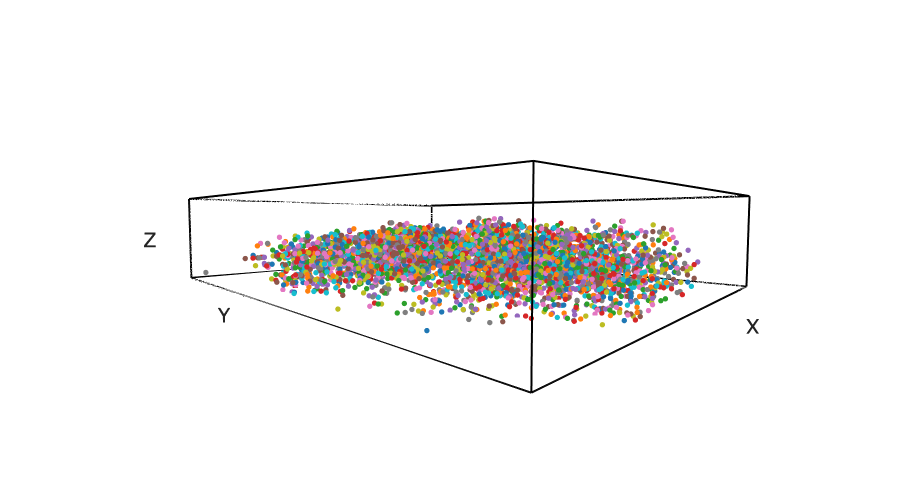

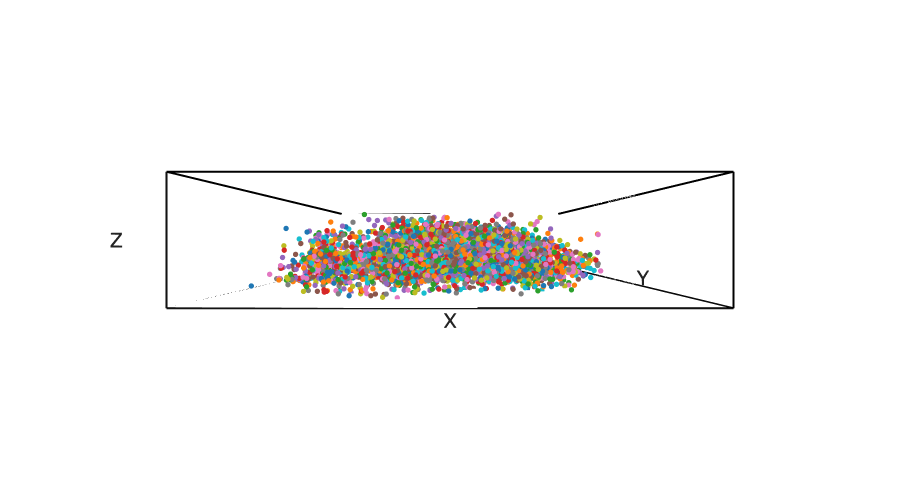

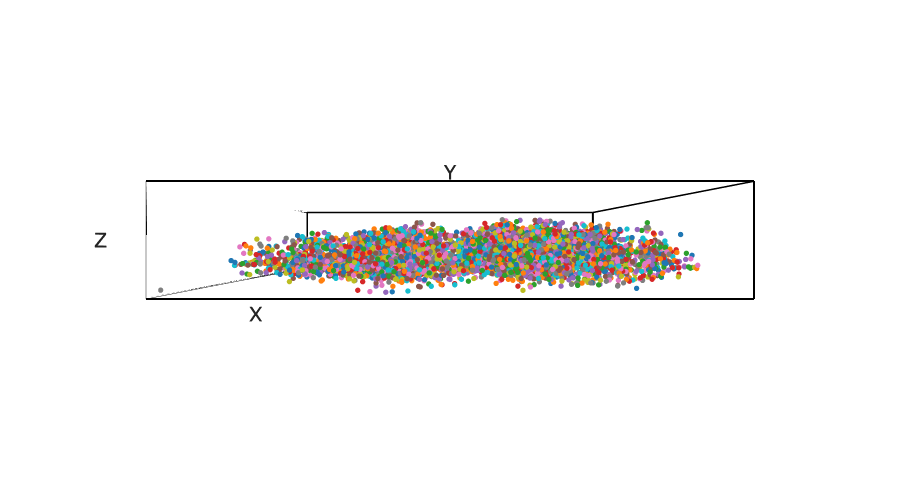

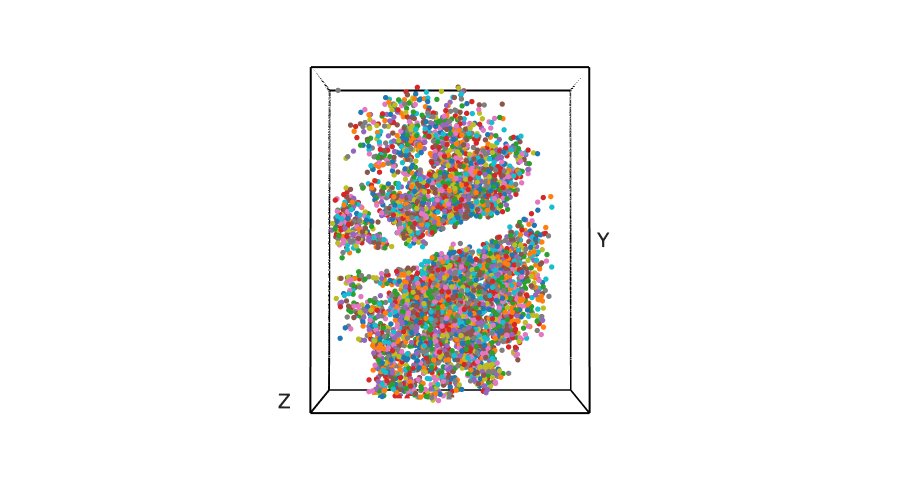

In [44]:
import glob
import numpy as np
from skimage.measure import label, regionprops
import plotly.express as px
import plotly.io as pio
import pandas as pd

file_path = "/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/rAAV/"
exp_names = [
    "retr02",
#     "retr00",
#     "retr04",
#     "retr07",
#     "retr08",
#     "retr09",
#     "retr10"
            ]

slopes = [50]

for exp in exp_names:
    curr_path = file_path + exp + "/"
    file_name = glob.glob(curr_path + "*.npy")
    in_data = np.load(file_name[0], allow_pickle=True)
    data = in_data.item()
    # in_angle = np.loadtxt(curr_path + glob.glob(curr_path + "*.csv"))
    # There must be a better way
    def draw_bbox(xlims, ylims, zlims):
        X = []
        Y = []
        Z = []
        for x in xlims:
            for y in ylims:
                for z in zlims:
                    X.append(x)
                    Y.append(y)
                    Z.append(z)
        for x in xlims:
            for z in zlims:
                for y in ylims:
                    X.append(x)
                    Y.append(y)
                    Z.append(z)
        for z in zlims:
            for y in ylims:
                for x in xlims:
                    X.append(x)
                    Y.append(y)
                    Z.append(z)
        return X, Y, Z

    masks = data["masks"]
    regions = regionprops(masks)

    X, Y, Z = draw_bbox([795,0], [-899,0], [-masks.shape[0]-1,0])
    df = pd.DataFrame(dict(
        X=X, 
        Y=Y, 
        Z=Z,
        line_group=np.repeat(range(int(len(X)/2)), 2)
                     ))
    fig = px.line_3d(df, x='X', y='Y', z='Z', line_group='line_group', template="simple_white")
    fig.update_traces(line_color="black", line_width=4)
    for region in regions:
        z, y, x = region.centroid
        y -= 899
        z -= (masks.shape[0]-1)
        v = np.array((x, y, z))
        r1 = R.from_euler('z', -5, degrees=True)
        r2 = R.from_euler('x', 2, degrees=True)
        r3 = R.from_euler('z', 5, degrees=True)
        v1 = np.matmul(r1.as_matrix(), v)
        v2 = np.matmul(r2.as_matrix(), v1)
        x, y, z = np.matmul(r3.as_matrix(), v2)
        fig.add_scatter3d(x=[x], y=[y], z=[z])
    camera = dict(eye=dict(x=12, y=12, z=0.85))
    fig.update_layout(
        scene = dict(
            xaxis = dict(ticks="", range=[795, 0], showgrid=False, showticklabels=False, title_font_size=20),
            yaxis = dict(ticks="", range=[-899, 0], showgrid=False, showticklabels=False, title_font_size=20),
            zaxis = dict(ticks="", range=[-masks.shape[0]-1, 0], showgrid=False, showticklabels=False, title_font_size=20),
            aspectmode="manual",
            aspectratio=dict(x=13.7, y=17, z=(masks.shape[0]*5)/100),),
        width=900,
        showlegend=False,
        scene_camera=camera
                    )
    fig.update_traces(marker=dict(size=3,
                                  opacity=1))
    fig.show("png")
    # pio.write_image(fig, curr_path + "XYZ_view.png", scale=3)

    fig.update_layout(scene_camera=dict(eye=dict(x=0, y=19, z=0)))
    fig.show("png")
    # pio.write_image(fig, curr_path + "XZ_view.png", scale=3)

    fig.update_layout(scene_camera=dict(eye=dict(x=19, y=0, z=0)))
    fig.show("png")
    # pio.write_image(fig, curr_path + "YZ_view.png", scale=3)

    fig.update_layout(scene_camera=dict(eye=dict(x=0, y=0.1, z=23)))
    fig.show("png")
    # pio.write_image(fig, curr_path + "XY_view.png", scale=3)